In [1]:
import os
import re
import json
import glob
import pickle
import string
import itertools
import collections
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

In [2]:
tqdm.pandas()

In [3]:
pd.set_option('display.max_rows', 10)

In [4]:
# input path
SUPPORT_PATH = "../data/supports"

In [5]:
def read_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [6]:
d_199 = read_pickle(os.path.join(SUPPORT_PATH, "parsed_199.pkl"))
d_6725 = read_pickle(os.path.join(SUPPORT_PATH, "parsed_7003.pkl"))

In [7]:
d_tweets = pd.concat([d_199, d_6725], axis = 0, sort=False)
d_tweets.drop_duplicates(subset="id_tweet", inplace=True)
d_tweets.reset_index(drop=True, inplace=True)

In [8]:
d_label = pd.read_csv("../data/account_labeled/label_updated.csv")

In [9]:
d_label.head()

,screen_name,label
0,4SinCong,NaN
1,4rdipratama,NaN
2,ABackBone,NaN
3,ARUL77039666,NaN
4,ATAP03167829,NaN


In [10]:
d_label.shape

(41756, 2)

In [11]:
d_tweets.head()

,screen_name,id_tweet,full_text,hashtags,user_mentions,created_at,quote_is_quote_status,quote_screen_name,quote_id_tweet,quote_full_text,quote_hashtags,quote_user_mentions,quote_created_at,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name
0,212Ujee2,1272955449160040449,#HapusRUUHIPDariMukaBumi \n#HapusRUUHIPDariMuk...,"[{'text': 'HapusRUUHIPDariMukaBumi', 'indices'...",[],Tue Jun 16 18:13:24 +0000 2020,True,Par3w4_Minang,1272901801516335112,Moncong putih ingin cuci tangan \n\nKata si Po...,[],[],Tue Jun 16 14:40:13 +0000 2020,NaN,NaN,NaN
1,212Ujee2,1272573148974571526,Sampah n benalu\nPerusak demokrasi wajib kita ...,"[{'text': 'BuzzeRpPublicEnemy', 'indices': [59...",[],Mon Jun 15 16:54:16 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,212Ujee2,1272242834725208064,Saatnya kita bersatu\nWahai umat Islam\n\n#Sto...,"[{'text': 'Stop_RUUHIP', 'indices': [39, 51]},...",[],Sun Jun 14 19:01:43 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,212Ujee2,1267860265694978049,Umat Islam\nHrs diam \nTerus sampai kapan?\nKe...,"[{'text': 'BalikinDanaHaji', 'indices': [104, ...",[],Tue Jun 02 16:46:57 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,212Ujee2,1266354000716107780,Hai Pemimpin !!!\nApakah udh ga ada lagi \nPro...,"[{'text': 'DirutBokep', 'indices': [204, 215]}...","[{'screen_name': '__p3jalan____', 'name': 'p3j...",Fri May 29 13:01:36 +0000 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
d_tweets.shape

(1983967, 16)

In [13]:
d_label = d_label[~d_label.label.isna()]

In [14]:
d_label.head()

,screen_name,label
34900,007koteka,1.0
34901,02Trus,1.0
34902,02fc71ba00c2451,1.0
34903,0b4tk3lu4r94,0.0
34904,0m_Brewoks2,0.0


In [15]:
d_label.label.value_counts()

0.0    4978
1.0    1878
Name: label, dtype: int64

In [16]:
# 2797 accounts are labeled, the rest are excluded before parsing
d_tweets[d_tweets.screen_name.isin(d_label.screen_name)].screen_name.unique().shape

(6856,)

In [17]:
d_dataset = d_tweets.groupby('screen_name')['full_text'].apply(list)
d_dataset = d_dataset.reset_index()

# join dataset and label
d_dataset = d_dataset.join(d_label.set_index('screen_name'), on='screen_name')

In [18]:
def get_profile_key(screen_name, key):
    profile_path = os.path.join(f"../data/profile/{screen_name}.json")
    if os.path.exists(profile_path):
        with open(profile_path) as f:
            data = json.load(f)
            if isinstance(data, dict):
                return data.get(key, None)
            else:
                return None

In [19]:
# get verified
d_dataset["is_verified"] = d_dataset.screen_name.progress_apply(get_profile_key, args=('verified', ))

100%|███████████████████████████████████████████████████████████████████████████| 6856/6856 [00:00<00:00, 13467.81it/s]


In [20]:
d_dataset.is_verified.value_counts()

False    2981
True       95
Name: is_verified, dtype: int64

In [21]:
# get description profile
d_dataset["profile_description"] = d_dataset.screen_name.progress_apply(get_profile_key, args=('description', ))

100%|███████████████████████████████████████████████████████████████████████████| 6856/6856 [00:00<00:00, 13748.69it/s]


In [22]:
def check_akun_resmi(description):
    if description:
        if re.search("akun .* resmi", description.lower()):
            return True
        else:
            return False
    else:
        return False

In [23]:
d_dataset["is_akun_resmi"] = d_dataset.profile_description.apply(check_akun_resmi)

In [24]:
d_dataset.loc[:, 'num_tweets'] = d_dataset.full_text.apply(lambda x : len(x))

In [25]:
d_dataset.label.value_counts()

0.0    4978
1.0    1878
Name: label, dtype: int64

In [26]:
d_dataset2 = d_dataset[d_dataset.num_tweets >= 20]

In [27]:
d_dataset.shape

(6856, 7)

In [28]:
d_dataset2.shape

(6720, 7)

In [29]:
d_dataset2.label.value_counts()

0.0    4876
1.0    1844
Name: label, dtype: int64

In [30]:
# using n samples
n_tweets = 5
d_dataset2['text_used'] = d_dataset2.full_text.apply(lambda x: " ".join(x[:n_tweets]))

<ipython-input-30-ae763a85b7fa>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d_dataset2['text_used'] = d_dataset2.full_text.apply(lambda x: " ".join(x[:n_tweets]))


In [31]:
d_dataset2.shape

(6720, 8)

In [32]:
d_dataset2 = d_dataset2[d_dataset2.label.notna()]

In [33]:
d_dataset2.reset_index(drop=True, inplace=True)

In [34]:
d_dataset2.shape

(6720, 8)

In [35]:
def text_cleansing(title):
    punctuation = '!"#$%&\'()*+,-./:;=?@[\\]^_`{|}~'
    table = str.maketrans(punctuation, ' '*len(punctuation)) #map punctuation to space
    
    # parse hashtag
    title = re.sub(r"([a-z])([A-Z])", r"\1 \2", title)
    # lowercase
    title = title.lower()
    # convert hyperlinks to link
#     title = re.sub('http(s):/\/\\S+', '<LINK> ', title)
    title = re.sub('http(s):/\/\\S+', ' ', title)
    # convert @username to username
#     title = re.sub('@\w+', '<USERNAME>', title)
    title = re.sub('@\w+', ' ', title)
    # remove punctuation
    title = title.translate(table)
    # only take string started with alphanum
    title = re.sub("[^(\w|\<\>)]", ' ', title)
    # remove double whitespaces
    title = re.sub('\s+', ' ', title)
    # remove double whitespaces
    title = title.strip()
    # tokenize text
    tokens = word_tokenize(title)
    # filter tokens more than 2 characters
    tokens = list(filter(lambda x: len(x) > 2, tokens))
    # filter tokens not numeric only
    tokens = list(filter(lambda x: not x.isnumeric(), tokens))
    # revert to string
    title = " ".join(tokens)
    
    return title

In [36]:
d_dataset2["preprocessed_text"] = d_dataset2.text_used.apply(text_cleansing)

In [37]:
d_dataset2

,screen_name,full_text,label,is_verified,profile_description,is_akun_resmi,num_tweets,text_used,preprocessed_text
0,007koteka,[#HariJadiTwitterSaya \n28 Juni 2017 https://t...,1.0,False,- Jadilah Penyejuk Hati yang Gersang l \n ...,False,300,#HariJadiTwitterSaya \n28 Juni 2017 https://t....,hari jadi twitter saya juni penjilat yang berk...
1,02Trus,[RT @SaveMoslem1: *Asyeeekkk.... PDIP kena jeb...,1.0,None,None,False,300,RT @SaveMoslem1: *Asyeeekkk.... PDIP kena jeba...,moslem1 asyeeekkk pdip kena jebakan batman fra...
2,02fc71ba00c2451,"[Salah ketik, salah hitung, salah input, salah...",1.0,False,benci dengan kemunafikan,False,300,"Salah ketik, salah hitung, salah input, salah ...",salah ketik salah hitung salah input salah sia...
3,0b4tk3lu4r94,[Sebentar....bentar gue hrs inget2 nih berukny...,0.0,False,Bergerak dan berdoa teros ajah,False,300,Sebentar....bentar gue hrs inget2 nih beruknya...,sebentar bentar gue hrs inget2 nih beruknya sa...
4,0m_Brewoks2,"[Bismillah. Bagi Yg minat kaos,topi #ManusiaMe...",0.0,None,None,False,300,"Bismillah. Bagi Yg minat kaos,topi #ManusiaMer...",bismillah bagi minat kaos topi manusia merdeka...
...,...,...,...,...,...,...,...,...,...
6715,zulfikarzat31,[Baru saja mengirim foto https://t.co/xh415Eyj...,0.0,False,"💗Di beranda, kita pernah lupa bahwa cinta bisa...",False,300,Baru saja mengirim foto https://t.co/xh415Eyj2...,baru saja mengirim foto ijin share qah sisa ha...
6716,zulhermansyah97,[👁 Siapa yang melawat profil anda? 👁\n@ArifinN...,0.0,False,Lelah 🔜 Lillah,False,300,👁 Siapa yang melawat profil anda? 👁\n@ArifinNa...,siapa yang melawat profil anda naftalia min so...
6717,zulkifli_abdul9,[Ini kenapa aku gak segampang itu ngambil kese...,0.0,False,"Football manager addict, ava nya alim orang ny...",False,300,Ini kenapa aku gak segampang itu ngambil kesem...,ini kenapa aku gak segampang itu ngambil kesem...
6718,zulman1,[Hmm bisa di coba ini wkwkw https://t.co/qCGES...,0.0,False,Juru tulis kapal bajak laut yang sedang berlay...,False,300,Hmm bisa di coba ini wkwkw https://t.co/qCGESp...,hmm bisa coba ini wkwkw cgesp wyw garuda dadak...


In [38]:
d_dataset2.label = d_dataset2.label.astype(int)

In [39]:
d_dataset2.label.value_counts()

0    4876
1    1844
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

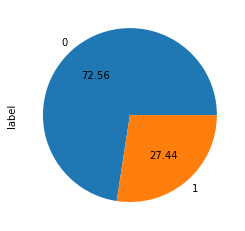

In [40]:
d_dataset2.label.value_counts().plot(kind='pie', autopct='%.2f')

#### Creating Count Matrix

In [41]:
d_dataset2.head()

,screen_name,full_text,label,is_verified,profile_description,is_akun_resmi,num_tweets,text_used,preprocessed_text
0,007koteka,[#HariJadiTwitterSaya \n28 Juni 2017 https://t...,1,False,- Jadilah Penyejuk Hati yang Gersang l \n ...,False,300,#HariJadiTwitterSaya \n28 Juni 2017 https://t....,hari jadi twitter saya juni penjilat yang berk...
1,02Trus,[RT @SaveMoslem1: *Asyeeekkk.... PDIP kena jeb...,1,None,None,False,300,RT @SaveMoslem1: *Asyeeekkk.... PDIP kena jeba...,moslem1 asyeeekkk pdip kena jebakan batman fra...
2,02fc71ba00c2451,"[Salah ketik, salah hitung, salah input, salah...",1,False,benci dengan kemunafikan,False,300,"Salah ketik, salah hitung, salah input, salah ...",salah ketik salah hitung salah input salah sia...
3,0b4tk3lu4r94,[Sebentar....bentar gue hrs inget2 nih berukny...,0,False,Bergerak dan berdoa teros ajah,False,300,Sebentar....bentar gue hrs inget2 nih beruknya...,sebentar bentar gue hrs inget2 nih beruknya sa...
4,0m_Brewoks2,"[Bismillah. Bagi Yg minat kaos,topi #ManusiaMe...",0,None,None,False,300,"Bismillah. Bagi Yg minat kaos,topi #ManusiaMer...",bismillah bagi minat kaos topi manusia merdeka...


In [42]:
d_dataset2.shape

(6720, 9)

In [43]:
d_dataset2['preprocessed_text_token'] = d_dataset2.preprocessed_text.apply(word_tokenize)

In [44]:
d_dataset2.head()

,screen_name,full_text,label,is_verified,profile_description,is_akun_resmi,num_tweets,text_used,preprocessed_text,preprocessed_text_token
0,007koteka,[#HariJadiTwitterSaya \n28 Juni 2017 https://t...,1,False,- Jadilah Penyejuk Hati yang Gersang l \n ...,False,300,#HariJadiTwitterSaya \n28 Juni 2017 https://t....,hari jadi twitter saya juni penjilat yang berk...,"[hari, jadi, twitter, saya, juni, penjilat, ya..."
1,02Trus,[RT @SaveMoslem1: *Asyeeekkk.... PDIP kena jeb...,1,None,None,False,300,RT @SaveMoslem1: *Asyeeekkk.... PDIP kena jeba...,moslem1 asyeeekkk pdip kena jebakan batman fra...,"[moslem1, asyeeekkk, pdip, kena, jebakan, batm..."
2,02fc71ba00c2451,"[Salah ketik, salah hitung, salah input, salah...",1,False,benci dengan kemunafikan,False,300,"Salah ketik, salah hitung, salah input, salah ...",salah ketik salah hitung salah input salah sia...,"[salah, ketik, salah, hitung, salah, input, sa..."
3,0b4tk3lu4r94,[Sebentar....bentar gue hrs inget2 nih berukny...,0,False,Bergerak dan berdoa teros ajah,False,300,Sebentar....bentar gue hrs inget2 nih beruknya...,sebentar bentar gue hrs inget2 nih beruknya sa...,"[sebentar, bentar, gue, hrs, inget2, nih, beru..."
4,0m_Brewoks2,"[Bismillah. Bagi Yg minat kaos,topi #ManusiaMe...",0,None,None,False,300,"Bismillah. Bagi Yg minat kaos,topi #ManusiaMer...",bismillah bagi minat kaos topi manusia merdeka...,"[bismillah, bagi, minat, kaos, topi, manusia, ..."


In [45]:
vocab = itertools.chain.from_iterable(d_dataset2.preprocessed_text_token.tolist())

In [46]:
vocab = list(vocab)

In [47]:
word_freq = collections.Counter(vocab)

In [48]:
d_word_freq = pd.DataFrame(data=word_freq.items(), columns=["word", "freq"])

In [49]:
d_word_freq = d_word_freq.sort_values("freq", ascending=False)

In [50]:
d_word_freq = d_word_freq[d_word_freq.freq > 1]

In [51]:
word_selected = d_word_freq.word.tolist()

In [52]:
vocab = ['PAD', 'UNK'] + word_selected

### LSTM Model

In [53]:
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [54]:
d_train, d_test = train_test_split(d_dataset2)

In [55]:
d_train.loc[:, "token_length"] = d_train.preprocessed_text_token.apply(len)

C:\Users\andreaschandra\miniconda3\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\andreaschandra\miniconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [56]:
d_test.loc[:, "token_length"] = d_test.preprocessed_text_token.apply(len)

In [57]:
d_train = d_train.sort_values("token_length")

In [58]:
d_test = d_test.sort_values("token_length")

In [59]:
d_train.reset_index(drop=True, inplace=True)
d_test.reset_index(drop=True, inplace=True)

In [60]:
class TwitterDataset(Dataset):
    def __init__(self, d_train, d_test):
        self.dataset = {
            'train': (d_train, len(d_train)),
            'test': (d_test, len(d_test))
        }
        
        self.set_split(split="train")
        
    def set_split(self, split="train"):
        self.data, self.length = self.dataset[split]
        
    def __getitem__(self, index):
        tokens = self.data.loc[index, 'preprocessed_text_token']
        label = self.data.loc[index, 'label']
        
        idx_tokens = []
        for token in tokens:
            try:
                idx_tokens.append(vocab.index(token))
            except:
                idx_tokens.append(1)
                
        tokens = torch.tensor(idx_tokens, dtype=torch.long)
        
        return (tokens, label)
    
    def __len__(self):
        return self.length

In [64]:
class Architecture(nn.Module):
    def __init__(self, num_vocab, emb_size, hidden_size, num_layer, dropout, is_bidirectional):
        super(Architecture, self).__init__()
        self.model = nn.Sequential(
            nn.Embedding(len(vocab), emb_size),
            nn.LSTM(emb_size, 
                    hidden_size, 
                    num_layers=num_layer, 
                    bias=False, 
                    batch_first=True, 
                    dropout=dropout, 
                    bidirectional=is_bidirectional)
        )
        
        self.fc1 = nn.Linear(hidden_size, 512)
        self.fc2 = nn.Linear(512, 1)
         
    def forward(self, input_):
        out, (h, c) = self.model(input_)
        out = self.fc1(out[:, -1, :])
        out = self.fc2(out)
        
        out = torch.sigmoid(out)
        
        return out

In [65]:
dataset = TwitterDataset(d_train, d_test)

In [66]:
x, y = dataset.__getitem__(0)

In [83]:
num_vocab = len(vocab)
emb_size = 512
hidden_size = 256
num_layer = 1
dropout = 0
is_bidirectional=False

In [84]:
model = Architecture(num_vocab, emb_size, hidden_size, num_layer, dropout, is_bidirectional)

In [85]:
num_params = sum([p.numel() for p in model.parameters()])

In [86]:
print(f"Total trainable parameters: {num_params:,}")

Total trainable parameters: 12,776,449


In [87]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [88]:
def padding(data):
    x, y = zip(*data)
    
    x = pad_sequence(x, batch_first=True)
    y = torch.Tensor(y)
    
    return (x, y)

In [90]:
batch_size = 512

In [91]:
model = model.cuda()

In [92]:
def calculate_accuracy(y_pred, y_true):
    y_pred = (y_pred > 0.5).long()
    n_correct = torch.eq(y_pred, y_true).sum().item()
    
    accuracy = (n_correct / len(y_true)) * 100
    
    return accuracy

In [ ]:
for epoch in range(1, 101):
    
    start = time.time()
    
    running_loss = 0
    running_loss_v = 0
    running_acc = 0
    running_acc_v = 0
    
    dataset.set_split(split="train")
    data_gen = DataLoader(dataset, batch_size=batch_size, collate_fn=padding)
    model.train()
    for batch_index, (x, y) in enumerate(data_gen, 1):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        
        out = model(x)
        out = out.squeeze()
        
        loss = criterion(out , y)
        loss.backward()
        running_loss += (loss.item() - running_loss) / batch_index 
        
        accuracy = calculate_accuracy(out, y)
        running_acc += (accuracy - running_acc) / batch_index
        
        optimizer.step()
        
    dataset.set_split(split="test")
    data_gen = DataLoader(dataset, batch_size=batch_size, collate_fn=padding)
    model.eval()
    for batch_index, (x, y) in enumerate(data_gen, 1):
        x = x.cuda()
        y = y.cuda()
        
        with torch.no_grad():
            out = model(x)
            out = out.squeeze()
            
        loss = criterion(out, y)
        running_loss_v += (loss.item() - running_loss_v) / batch_index
        
        accuracy = calculate_accuracy(out, y)
        running_acc_v += (accuracy - running_acc_v) / batch_index
    
    duration = time.time() - start
    print(f"epoch: {epoch} | time: {duration:.1f}s")
    print(f"\t train loss: {running_loss:.2f} | accuracy: {running_acc:.2f}")
    print(f"\t val loss: {running_loss_v:.2f} | accuracy: { running_acc_v:.2f}")

epoch: 1 | time: 31.9s
	 train loss: 0.63 | accuracy: 68.09
	 val loss: 0.58 | accuracy: 74.93
epoch: 2 | time: 29.8s
	 train loss: 0.63 | accuracy: 72.46
	 val loss: 0.57 | accuracy: 74.93
epoch: 3 | time: 29.9s
	 train loss: 0.60 | accuracy: 72.58
	 val loss: 0.58 | accuracy: 74.93
epoch: 4 | time: 30.1s
	 train loss: 0.60 | accuracy: 72.66
	 val loss: 0.56 | accuracy: 74.93
epoch: 5 | time: 30.6s
	 train loss: 0.58 | accuracy: 72.72
	 val loss: 0.57 | accuracy: 74.93
epoch: 6 | time: 30.5s
	 train loss: 0.58 | accuracy: 72.89
	 val loss: 0.56 | accuracy: 75.15
epoch: 7 | time: 29.8s
	 train loss: 0.53 | accuracy: 74.24
	 val loss: 0.51 | accuracy: 74.70
epoch: 8 | time: 30.4s
	 train loss: 0.61 | accuracy: 73.10
	 val loss: 0.55 | accuracy: 77.08
epoch: 9 | time: 30.0s
	 train loss: 0.53 | accuracy: 79.90
	 val loss: 0.53 | accuracy: 77.73
epoch: 10 | time: 29.9s
	 train loss: 0.44 | accuracy: 83.58
	 val loss: 0.47 | accuracy: 79.60
epoch: 11 | time: 29.6s
	 train loss: 0.35 | accu